In [33]:
!pip install pytorch_lightning
!pip install neuralforecast

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer
from neuralforecast.losses.pytorch import MAE
from google.colab import files
uploaded = files.upload()

Saving hanoi_quality.csv to hanoi_quality.csv


In [36]:
def smoothed(data):
    # Áp dụng bộ lọc trung bình động để làm mượt các giá trị dự báo
    window_size = 5
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Nội suy các giá trị NaN kết quả từ trung bình động
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Điền các giá trị NaN còn lại
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # hoặc 'ffill', hoặc dùng fillna(value=0)

    return forecast_smoothed_filled

In [37]:
data = pd.read_csv('hanoi_quality.csv')

# Thay thế cột 'date' bằng chỉ số từ 0 đến N-1
data['index'] = np.arange(len(data))

# Chuẩn bị dữ liệu cho mô hình
data['unique_id'] = 'pm25'
data['y'] = data['pm25']
data['ds'] = data['index']

# Làm mượt dữ liệu
data['y_smooth'] = smoothed(data['y'])

# Chia dữ liệu thành train và test theo tỉ lệ 7:3
split_idx = int(len(data) * 0.7)
train_data = data[:split_idx].copy()
test_data = data[split_idx:].copy()

# Chỉ giữ lại các cột cần thiết
train_data = train_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})
test_data = test_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})

In [38]:
# Khởi tạo và huấn luyện mô hình
import torch
model = Autoformer(
    h=len(test_data),  # forecast horizon
    input_size=30,  # maximum sequence length
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

nf.fit(df=train_data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [39]:
# Dự đoán trên tập test
forecasts = nf.predict(futr_df=test_data)
predictions = forecasts['Autoformer'].values

# Smooth the predictions
predictions_smoothed = smoothed(pd.Series(predictions)).values

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [40]:
# Đánh giá mô hình
y_true = test_data['y'].values
y_pred = predictions_smoothed

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 50.07624278967783
MAE: 41.07262055741416
MAPE: 44.73307316711556


In [41]:
model = Autoformer(
    h=90,  # forecast horizon
    input_size=30,  # maximum sequence length (Sử dụng 30 bước thời gian trước đó làm đầu vào.)
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

# Chỉ giữ lại các cột cần thiết
data = data[['unique_id', 'ds', 'y']]

nf.fit(df=data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [42]:
future_data = pd.DataFrame({
    'unique_id': ['pm25'] * 90,
    'ds': np.arange(len(data), len(data) + 90),
    'y': [np.nan] * 90
})

# Dự báo 90 ngày tiếp theo
forecasts = nf.predict(futr_df=future_data)
future_predictions = forecasts['Autoformer'].values

# Tách dữ liệu dự đoán thành 3 phần
future_predictions_1_30 = future_predictions[:30]
future_predictions_31_60 = future_predictions[30:60]
future_predictions_61_90 = future_predictions[60:]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [43]:
# In ra các dự đoán
print("90D Predictions:")
print(future_predictions)

90D Predictions:
[71.17055  79.47056  78.31346  74.13268  73.60523  71.925644 66.59781
 64.3079   66.312935 62.65889  58.879025 58.09226  59.62646  63.783306
 62.52971  64.31355  61.64171  63.371765 62.384155 61.82647  61.21396
 60.611134 62.76504  60.974    60.04685  59.990948 63.11555  61.825294
 62.021317 61.06728  64.57686  64.48117  64.02838  63.522594 62.84424
 62.973396 63.24735  62.769043 61.113564 61.13758  61.142002 61.697277
 61.080933 60.916134 60.81453  60.748245 60.690876 60.668556 60.680187
 60.684364 60.678726 60.44691  60.252335 60.120808 60.471794 60.80584
 61.11728  61.272533 61.350025 61.439007 61.659428 61.98872  62.187702
 62.22631  62.287212 62.157097 61.701202 61.343166 62.13568  61.164494
 60.43906  60.03295  59.62549  59.402786 59.633263 59.948387 60.091183
 60.540314 61.985867 65.03387  62.133926 61.883995 62.493843 62.83596
 63.2681   63.231075 62.404053 62.29205  62.988945 68.814026]


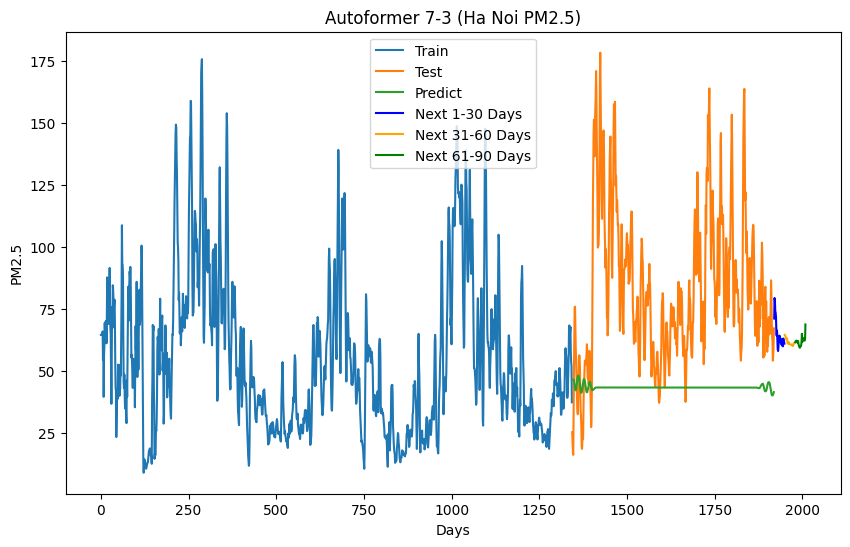

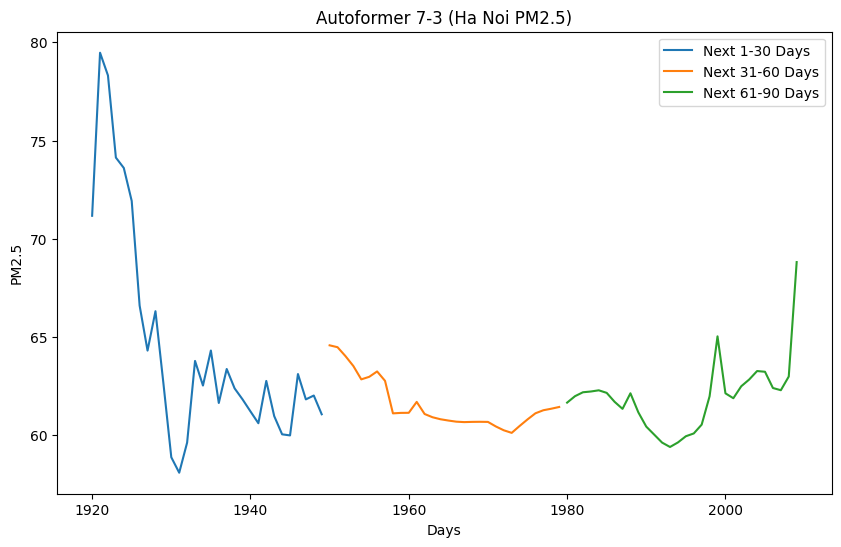

In [44]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], y_pred, label='Predict')
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 7-3 (Ha Noi PM2.5)')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='tab:blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='tab:orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='tab:green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 7-3 (Ha Noi PM2.5)')
plt.show()